<b>Importing the libraries

In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from torchvision import models,datasets,transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision.utils import make_grid
from torchvision.datasets import STL10
import itertools
import torch.optim as optim
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

<b>Downloading and defining Train & Test dataset

Transformation applied on Train & Test Data

In [ ]:
transform = transforms.Compose([
	transforms.ToTensor(),
])

In [ ]:
trainData = STL10('./data', split='train', transform=transform, download=True)
testData = STL10('./data', split='test', transform=transform, download=True)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


<b>Exploring STL10 dataset

In [ ]:
print("Train Dataset Size: ", len(trainData))
print("Shape: ", trainData.data.shape)
print("Test Dataset Size: ", len(testData))

Train Dataset Size:  5000
Shape:  (5000, 3, 96, 96)
Test Dataset Size:  8000


In [ ]:
classes = trainData.classes
print("Number of classes = ", len(classes))
print(classes)

Number of classes =  10
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


Shape of an Image tensor from dataset

In [ ]:
image, label = trainData[0]
image.shape

torch.Size([3, 96, 96])

Label (numeric): 0
Label (textual): airplane


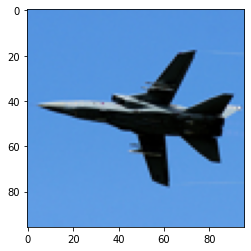

In [ ]:
image, label = trainData[200]
plt.imshow(image.permute((1, 2, 0)))
print('Label (numeric):', label)
print('Label (textual):', classes[label])

<b>Number of images belonging to each class

In [ ]:
classCount = {}
for i,j in trainData: 
    labels = classes[j]
    if labels not in classCount:
        classCount[labels] = 0
    classCount[labels] += 1 
classCount 

{'airplane': 500,
 'bird': 500,
 'car': 500,
 'cat': 500,
 'deer': 500,
 'dog': 500,
 'horse': 500,
 'monkey': 500,
 'ship': 500,
 'truck': 500}

<b>Creating DataLoaders to load the data in batches

In [ ]:
batch_size = 100
trainLoader = DataLoader(trainData, batch_size=batch_size, shuffle=True,num_workers=2,pin_memory =True)
testLoader = DataLoader(testData, batch_size=batch_size, shuffle=True,num_workers =2,pin_memory =True)

In [ ]:
train_images = trainData.data
train_labels =trainData.labels

test_labels= testData.labels
test_images= testData.data

<b>Visualizing the Batch Data

Images Shape: torch.Size([100, 3, 96, 96])


Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


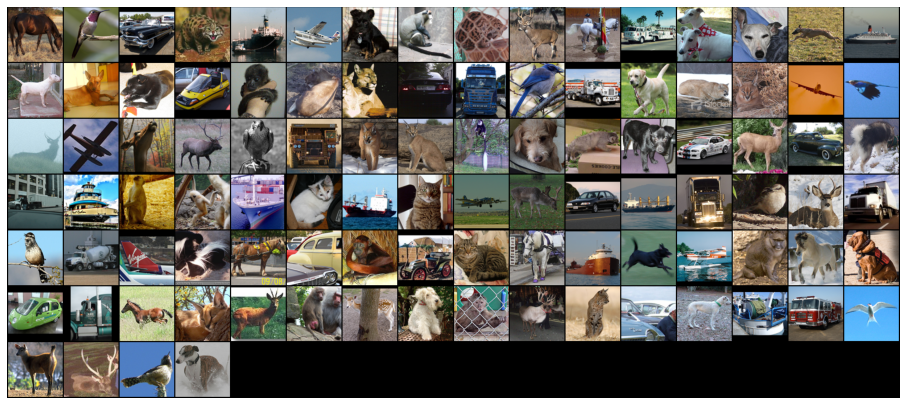

In [ ]:
for images, labels in trainLoader:
    print('Images Shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

Moving data and labels to GPU if available

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

<b> Using Pretrained ResNet50 model

In [ ]:
model = models.resnet50(pretrained=True)
model = model.to(device)

for param in model.parameters():
    param.requires_grad = False
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

<b>Removing the last FC layer

In [ ]:
newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
summary(newmodel, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

<b> Extracting the Features from ResNet50 model

In [ ]:
len(trainLoader)

50

In [ ]:
X_train=[]
for i, (images, labels) in enumerate(trainLoader):
  images = images.to(device)
  labels = labels.to(device)
  outputs = newmodel(images)
  for loop in range(batch_size):
    out = outputs.data[loop].detach().to("cpu").numpy()
    temp=out.tolist()
    temp = list(itertools.chain(*temp))
    temp = list(itertools.chain(*temp))
    X_train.append(temp)

In [ ]:
print("Length of X_train: ",len(X_train))
df_train = pd.DataFrame(X_train)
df_train.shape

Length of X_train:  5000


(5000, 2048)

In [ ]:
X_test=[]
for i, (images, labels) in enumerate(testLoader):
  images = images.to(device)
  labels = labels.to(device)
  outputs = newmodel(images)
  for loop in range(batch_size):
    out = outputs.data[loop].detach().to("cpu").numpy()
    temp=out.tolist()
    temp = list(itertools.chain(*temp))
    temp = list(itertools.chain(*temp))
    X_test.append(temp)

In [ ]:
print("Length of X_train",len(X_test))
df_test = pd.DataFrame(X_test)
df_test.shape

Length of X_train 8000


(8000, 2048)

<b>Train Test Data

In [ ]:
#df_train
print(df_train.shape)
Y_train =train_labels
print("Length of Y_train", len(Y_train))

(5000, 2048)
Length of Y_train 5000


In [ ]:
#df_test
print(df_test.shape)
Y_test =test_labels
print("Length of Y_test", len(Y_test))

(8000, 2048)
Length of Y_test 8000


Normalizing the data

In [ ]:
Xtrain = (df_train - np.min(df_train))/(np.max(df_train)-np.min(df_train)).values
Xtest = (df_test - np.min(df_test))/(np.max(df_test)-np.min(df_test)).values

<b>SVM Classifier

In [ ]:

model = svm.SVC(kernel='rbf', gamma=0.001,C=200)

In [ ]:
svm_model = model.fit(Xtrain,Y_train)

In [ ]:
#Prediction using SVM
X_train_pred = svm_model.predict(Xtrain)


In [ ]:
len(X_train_pred)

5000

<b>Accuracy

In [ ]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

In [ ]:
print("Accuracy: ", accuracy(Y_train, X_train_pred)) 

Accuracy:  0.8266


<b>Confusion Matrix

In [ ]:
y_actu = pd.Series(Y_train, name='Actual')
y_pred = pd.Series(X_train_pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred, margins=False)
print(df_confusion.to_numpy())

[[423   6  13  12   5   8  12   9   6   6]
 [  8 433   9   9   5   9   8   7   9   3]
 [ 18  18 404   9   8   7  13  10   5   8]
 [ 17   9   8 427   8   6   8   6   9   2]
 [ 12  16  13  11 407  11  10  11   7   2]
 [  9  12  13  18  10 408  12   8   5   5]
 [ 18  10  10   9   8  11 403  15  10   6]
 [ 27  11   6  12   5   8  15 407   2   7]
 [ 11  11   9  14   5   6  11  14 414   5]
 [  9  10  11  14  11   9  18   8   3 407]]


<b>ROC Curve

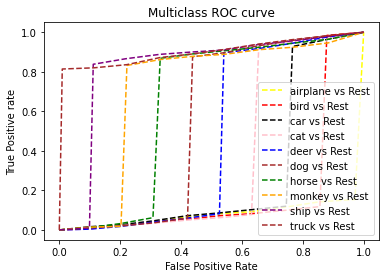

In [ ]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = len(classes)

colors=['yellow','red', 'black','pink', 'blue', 'brown', 'green','orange','purple','brown']
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_train, X_train_pred, pos_label=i)
    plt.plot(fpr[i], tpr[i], linestyle='--',color=colors[i], label= classes[i] +' vs Rest')

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=600);  

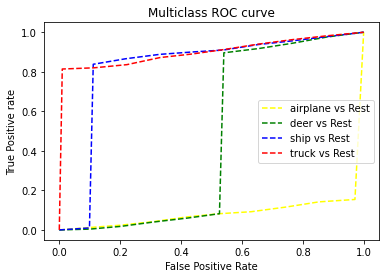

In [ ]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='yellow', label= classes[0] +' vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='green', label=classes[4] +' vs Rest')
plt.plot(fpr[8], tpr[8], linestyle='--',color='blue', label=classes[8] +' vs Rest')
plt.plot(fpr[9], tpr[9], linestyle='--',color='red', label=classes[9] +' vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);  

Test Data

In [ ]:
Xtest_pred = svm_model.predict(Xtest)

In [ ]:
print("Accuracy: ", accuracy(Y_test, Xtest_pred)) 

Accuracy:  0.10175


In [ ]:
y_actu = pd.Series(Y_test, name='Actual')
y_pred = pd.Series(Xtest_pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred, margins=False)
print(df_confusion.to_numpy())

[[ 88 146  98  94  58  81  88  51  40  56]
 [ 84 139 103  78  70  88  80  47  48  63]
 [ 78 117 106  91  68  77  82  60  38  83]
 [ 84 123 100  82  80  80  76  51  56  68]
 [ 82 121 117  79  70  93  65  49  44  80]
 [ 82 143 110  86  59  84  80  49  41  66]
 [ 70 142 101  87  70  84  79  56  42  69]
 [ 72 130 103  87  81  68  87  50  47  75]
 [ 96 124  98  87  80  90  62  41  47  75]
 [ 67 124 102  96  76  86  89  46  45  69]]


In [ ]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = len(classes)

colors=['yellow','red', 'black','pink', 'blue', 'brown', 'green','orange','purple','brown']
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, Xtest_pred, pos_label=i) 

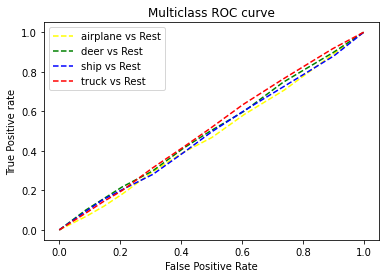

In [ ]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='yellow', label= classes[0] +' vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='green', label=classes[4] +' vs Rest')
plt.plot(fpr[8], tpr[8], linestyle='--',color='blue', label=classes[8] +' vs Rest')
plt.plot(fpr[9], tpr[9], linestyle='--',color='red', label=classes[9] +' vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);  